- Every graph has a node table and edge table

In [1]:
import pandas as pd
import networkx as nx
import os
import numpy as np
import warnings
import numpy as np
import matplotlib.pyplot as plt

from nxviz import CircosPlot
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import zipfile
# This block of code checks to make sure that a particular directory is present.
if "divvy_2013" not in os.listdir('datasets/'):
    print('Unzipping the divvy_2013.zip file in the datasets folder.')
    with zipfile.ZipFile("datasets/divvy_2013.zip","r") as zip_ref:
        zip_ref.extractall('datasets')

Unzipping the divvy_2013.zip file in the datasets folder.


In [4]:
stations = pd.read_csv('datasets/divvy_2013/Divvy_Stations_2013.csv', parse_dates=['online date'], encoding='utf-8')
stations.head(10)

,id,name,latitude,longitude,dpcapacity,landmark,online date
0,5,State St & Harrison St,41.873958,-87.627739,19,30,2013-06-28
1,13,Wilton Ave & Diversey Pkwy,41.932500,-87.652681,19,66,2013-06-28
2,14,Morgan St & 18th St,41.858086,-87.651073,15,163,2013-06-28
3,15,Racine Ave & 18th St,41.858181,-87.656487,15,164,2013-06-28
4,16,Wood St & North Ave,41.910329,-87.672516,15,223,2013-08-12
5,17,Wood St & Division St,41.903320,-87.672730,15,246,2013-06-28
6,19,Loomis St & Taylor St,41.869417,-87.660996,15,139,2013-06-28
7,20,Sheffield Ave & Kingsbury St,41.909592,-87.653497,15,154,2013-06-28
8,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,157,2013-06-28
9,22,May St & Taylor St,41.869482,-87.655486,15,160,2013-06-28


In [5]:
trips = pd.read_csv('datasets/divvy_2013/Divvy_Trips_2013.csv', 
                    parse_dates=['starttime', 'stoptime'])
trips.head(10)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthday
0,4118,2013-06-27 12:11:00,2013-06-27 12:16:00,480,316,85,Michigan Ave & Oak St,28,Larrabee St & Menomonee St,Customer,NaN,NaN
1,4275,2013-06-27 14:44:00,2013-06-27 14:45:00,77,64,32,Racine Ave & Congress Pkwy,32,Racine Ave & Congress Pkwy,Customer,NaN,NaN
2,4291,2013-06-27 14:58:00,2013-06-27 15:05:00,77,433,32,Racine Ave & Congress Pkwy,19,Loomis St & Taylor St,Customer,NaN,NaN
3,4316,2013-06-27 15:06:00,2013-06-27 15:09:00,77,123,19,Loomis St & Taylor St,19,Loomis St & Taylor St,Customer,NaN,NaN
4,4342,2013-06-27 15:13:00,2013-06-27 15:27:00,77,852,19,Loomis St & Taylor St,55,Halsted St & James M Rochford St,Customer,NaN,NaN
5,4480,2013-06-27 19:40:00,2013-06-27 22:28:00,27,10105,340,Clark St & Wrightwood Ave,46,Wells St & Walton St,Customer,NaN,NaN
6,4490,2013-06-27 18:45:00,2013-06-27 19:03:00,418,1094,37,Dearborn St & Adams St,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN
7,4592,2013-06-27 19:34:00,2013-06-27 19:51:00,170,1020,90,Millennium Park,75,Canal St & Jackson Blvd,Customer,NaN,NaN
8,4602,2013-06-27 19:45:00,2013-06-27 20:42:00,353,3419,37,Dearborn St & Adams St,37,Dearborn St & Adams St,Customer,NaN,NaN
9,4607,2013-06-27 19:46:00,2013-06-27 19:57:00,369,653,51,Clark St & Randolph St,340,Clark St & Wrightwood Ave,Customer,NaN,NaN


In [6]:
G = nx.DiGraph()

In [7]:
for d in stations.to_dict('records'): # each row is a dictionary
    node_id = d.pop('id')
    G.add_node(node_id, **d) 

In [9]:
counts = trips.groupby(['from_station_id', 'to_station_id'])['trip_id'].count().reset_index()
for d in counts.to_dict('records'):
    G.add_edge(d['from_station_id'], d['to_station_id'], count=d['trip_id'])

Text(0, 0.5, 'num. of edges')

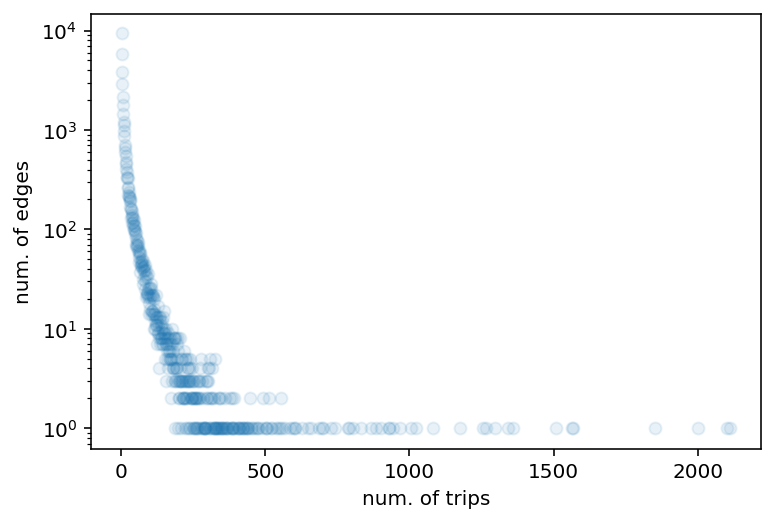

In [10]:
from collections import Counter
# Count the number of edges that have x trips recorded on them.
trip_count_distr = Counter([d['count'] for _, _, d in G.edges(data=True)])

# Then plot the distribution of these
plt.scatter(list(trip_count_distr.keys()), list(trip_count_distr.values()), alpha=0.1)
plt.yscale('log')
plt.xlabel('num. of trips')
plt.ylabel('num. of edges')

In [11]:
# Filter the edges to just those with more than 100 trips.
G_filtered = G.copy()
for u, v, d in G.edges(data=True):
    if d['count'] < 100:
        G_filtered.remove_edge(u,v)
        
len(G_filtered.edges())

1324

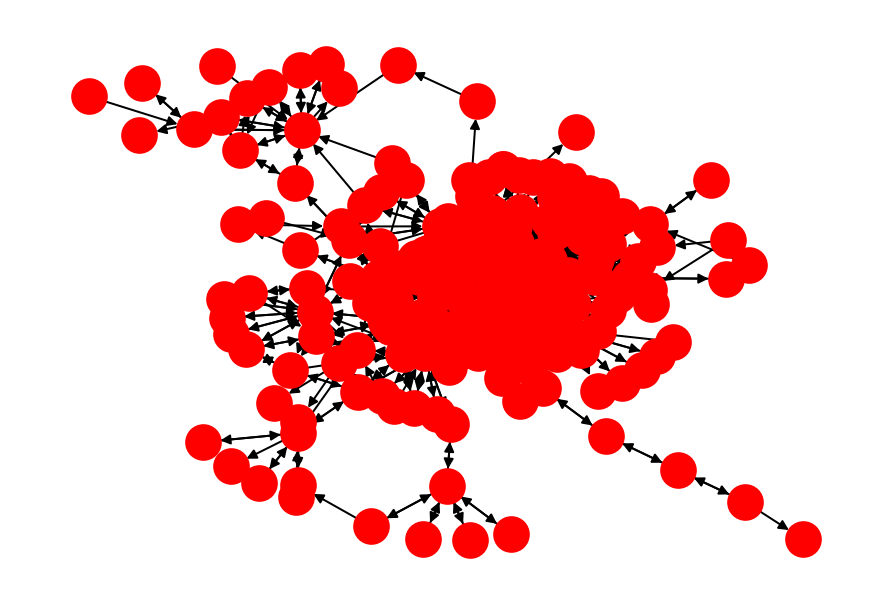

In [12]:
nx.draw_kamada_kawai(G_filtered)

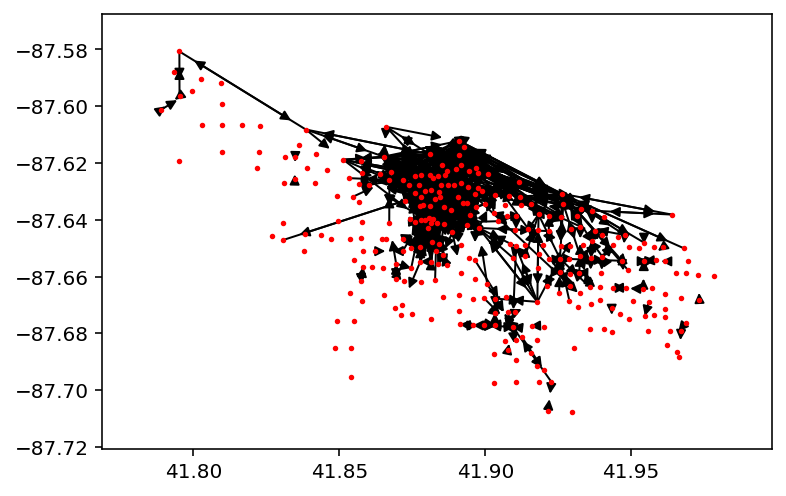

In [13]:
locs = {n: np.array([d['latitude'], d['longitude']]) for n, d in G_filtered.nodes(data=True)}
# for n, d in G_filtered.nodes(data=True):
#     print(n, d.keys())
nx.draw_networkx_nodes(G_filtered, pos=locs, node_size=3)
nx.draw_networkx_edges(G_filtered, pos=locs)
plt.show()

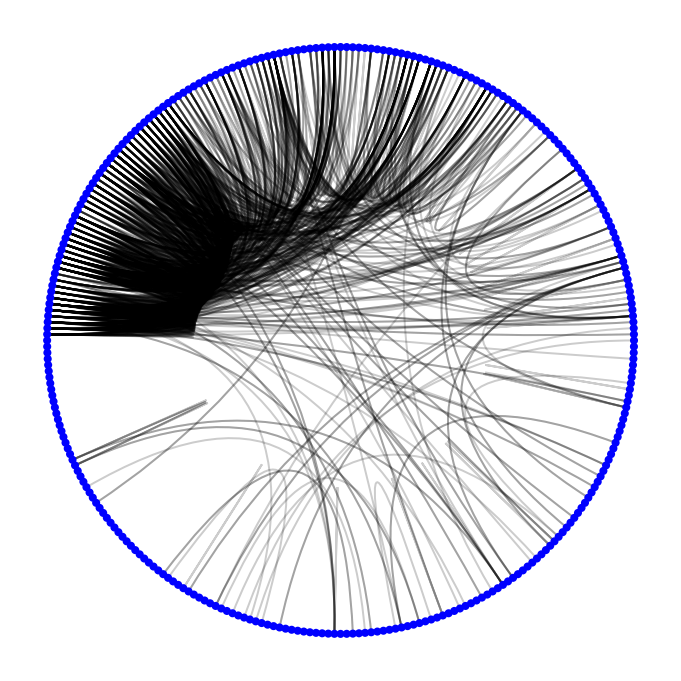

In [15]:
for n in G_filtered.nodes():
    G_filtered.node[n]['connectivity'] = len(list(G.neighbors(n)))

c = CircosPlot(G_filtered, node_order='connectivity')
c.draw()
plt.savefig('images/divvy.png', dpi=300)

In [16]:
nx.write_gpickle(G, 'datasets/divvy_2013/divvy_graph.pkl')

In [17]:
G = nx.read_gpickle('datasets/divvy_2013/divvy_graph.pkl')
list(G.nodes(data=True))[0:2]

[(5,
  {'name': 'State St & Harrison St',
   'latitude': 41.87395806,
   'longitude': -87.62773949,
   'dpcapacity': 19,
   'landmark': 30,
   'online date': Timestamp('2013-06-28 00:00:00')}),
 (13,
  {'name': 'Wilton Ave & Diversey Pkwy',
   'latitude': 41.93250008,
   'longitude': -87.65268082,
   'dpcapacity': 19,
   'landmark': 66,
   'online date': Timestamp('2013-06-28 00:00:00')})]